<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
!nvidia-smi

Thu Nov 21 23:16:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

# In case you don't have the right instance, go to the Runtime option on Google
# Colab then select change runtime type and make sure GPU is selcted. 
# If you get assigned a GPU which is not the Tesla T4, then go to runtime
# select Reset all runtimes and try to run again the first two cells of this 
# notebook
if device_name != b'Tesla T4':
  raise Exception("Unfortunately this instance does not have a T4 GPU.")
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [4]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

--2019-11-21 23:16:36--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   106MB/s    in 0.5s    

2019-11-21 23:16:42 (106 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-

In [0]:
# In case you get an import error, run again notebook cell number 3, 
# to install again miniconda and RAPIDS dependencies. If the problem persists,
# Go to Runtime -> Reset all runtimes and then run again the noebook cells (two 
# times the one for installing miniconda and RAPIDS dependencies)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
# Using Tesla T4 GPU on Google Colab

In [6]:
# Creating a linearly separable dataset using Gaussian Distributions.
# The first half of the number in Y is 0 and the other half 1.
# Therefore I made the first half of the 4 features quite different from
# the second half of the features (setting the value of the means quite 
# similar) so that make quite simple the classification between the 
# classes (the data is linearly separable).
dataset_len = 40000000
dlen = int(dataset_len/2)
X_11 = pd.Series(np.random.normal(2,2,dlen))
X_12 = pd.Series(np.random.normal(9,2,dlen))
X_1 = pd.concat([X_11, X_12]).reset_index(drop=True)
X_21 = pd.Series(np.random.normal(1,3,dlen))
X_22 = pd.Series(np.random.normal(7,3,dlen))
X_2 = pd.concat([X_21, X_22]).reset_index(drop=True)
X_31 = pd.Series(np.random.normal(3,1,dlen))
X_32 = pd.Series(np.random.normal(3,4,dlen))
X_3 = pd.concat([X_31, X_32]).reset_index(drop=True)
X_41 = pd.Series(np.random.normal(1,1,dlen))
X_42 = pd.Series(np.random.normal(5,2,dlen))
X_4 = pd.concat([X_41, X_42]).reset_index(drop=True)
Y = pd.Series(np.repeat([0,1],dlen))
df = pd.concat([X_1, X_2, X_3, X_4, Y], axis=1)
df.columns = ['X1', 'X2', 'X3', 'X_4', 'Y']
df.head()

,X1,X2,X3,X_4,Y
0,2.070468,1.634899,2.410713,0.827324,0
1,-0.452288,4.113088,1.844020,2.283463,0
2,1.168113,-2.340230,3.813162,0.893934,0
3,2.398900,4.816112,3.732294,1.453086,0
4,1.631141,-1.333464,2.995074,1.334284,0


In [7]:
train_size = 0.80
X = df.drop(['Y'], axis = 1).values
y = df['Y']

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels
y = label_encoder.fit_transform(y) 

# identify shape and indices
num_rows, num_columns = df.shape
delim_index = int(num_rows * train_size)

# Splitting the dataset in training and test sets
X_train, y_train = X[:delim_index, :], y[:delim_index]
X_test, y_test = X[delim_index:, :], y[delim_index:]

# Checking sets dimensions
print('X_train dimensions: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test dimensions:', X_test.shape, 'y_validation: ', y_test.shape)

# Checking dimensions in percentages
total = X_train.shape[0] + X_test.shape[0]
print('X_train Percentage:', (X_train.shape[0]/total)*100, '%')
print('X_test Percentage:', (X_test.shape[0]/total)*100, '%')

X_train dimensions:  (32000000, 4) y_train:  (32000000,)
X_test dimensions: (8000000, 4) y_validation:  (8000000,)
X_train Percentage: 80.0 %
X_test Percentage: 20.0 %


In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
%%time

params = {}
booster_params = {}
booster_params['tree_method'] = 'gpu_hist' 
params.update(booster_params)

clf = xgb.train(params, dtrain)

CPU times: user 1.42 s, sys: 719 ms, total: 2.14 s
Wall time: 2.51 s


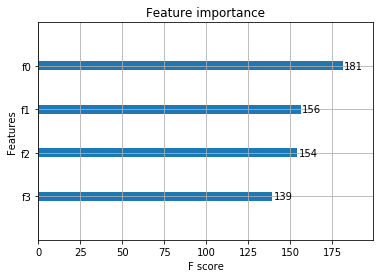

In [11]:
# Feature Importance plot!
xgb.plot_importance(clf)

In [12]:
rapids_pred = clf.predict(dtest)

rapids_pred = np.round(rapids_pred)
rapids_acc = round(accuracy_score(y_test, rapids_pred), 2)
print("XGB accuracy using RAPIDS:", rapids_acc*100, '%')

XGB accuracy using RAPIDS: 99.0 %
